# Mempersiapkan Package yang dipakai

In [0]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
from matplotlib.pyplot import imread
import zipfile,os

# Mengunduh berkas datsets

In [39]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2020-05-31 20:50:40--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  12.2MB/s    in 33s     

2020-05-31 20:51:14 (9.27 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



#Meng-ekstract data zip dan melihat isi foldernya

In [0]:
# ekstrac data
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [41]:
# melihat isi zip
os.listdir('/tmp')

['rockpaperscissors.zip', 'rockpaperscissors', '__MACOSX']

In [42]:
# memilih datasets rockpaperscissors dan melihat isinya
os.listdir('/tmp/rockpaperscissors')

['rock',
 'paper',
 'scissors',
 'rps-cv-images',
 'README_rpc-cv-images.txt',
 'rockpaperscissors',
 '__MACOSX']

#Image Preprocessing

In [43]:
# membuat data kasar
data_dir = '/tmp/rockpaperscissors/rockpaperscissors/rps-cv-images'
os.listdir(data_dir)

['rock', 'paper', 'scissors', 'README_rpc-cv-images.txt']

In [44]:

#augmentasi dan memisahkan data train dan validasi
aug = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    height_shift_range=.2,
    vertical_flip = True,
    validation_split=0.2
)
train_gen = aug.flow_from_directory(
    data_dir,
    target_size = (224,224), # dibuat 224 x 224 pixel
    batch_size = 32,
    class_mode = 'categorical',
    shuffle=True,
    subset='training'
)
val_gen = aug.flow_from_directory(
    data_dir,
    target_size=(224,224), # dibuat 224 x 224 pixel
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


# Membuat Model prediksi

In [45]:
model_base = MobileNet(weights='imagenet',
                       include_top=False, 
                       input_shape=(224,224,3))
model = Sequential()
model.add(model_base)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0,5))
model.add(Dense(3, activation='softmax'))
model.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


In [46]:
# memanggil kembali model yang paling baik
model_terbaik = './base.model'
cekpoin = ModelCheckpoint(
    model_terbaik,
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    period=1
)
stoping = EarlyStopping(
    monitor = 'val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tb = TensorBoard(
    log_dir = '.logs',
    histogram_freq = 0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False
)
csvlog = CSVLogger(
    filename='training_csv.log',
    separator = ",",
    append=False
)
pengurangan = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1,
    mode='auto',
    cooldown=1
)
callbacks = [cekpoin,tb,csvlog,pengurangan]

/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '
/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:97: UserWarning: The TensorBoard callback does not support gradients display when using TensorFlow 2.0. The `write_grads` argument is ignored.
  warnings.warn('The TensorBoard callback does not support '


# Training Data dengan Model terbaik

In [47]:
model.compile(
    loss='hinge',
    optimizer='SGD', # menggunakan optimizer SGD
    metrics=['accuracy']
)

gambar = model.fit_generator(
    train_gen, 
    steps_per_epoch = 26, #train dilakukan 26 kali
    validation_data = val_gen,#menampilkan score validasi
    validation_steps = 26, #validasi dilakukan 26 kali
    epochs = 5, # dibuat 5 kali
    verbose = 1, 
    callbacks=callbacks
)

Epoch 1/5
26/26 [==============================] - 275s 11s/step - loss: 0.9864 - accuracy: 0.5974 - val_loss: 1.1692 - val_accuracy: 0.4689

Epoch 00001: saving model to ./base.model
Epoch 2/5
26/26 [==============================] - 261s 10s/step - loss: 0.7618 - accuracy: 0.9599 - val_loss: 1.0175 - val_accuracy: 0.8383

Epoch 00002: saving model to ./base.model
Epoch 3/5
26/26 [==============================] - 277s 11s/step - loss: 0.7190 - accuracy: 0.9748 - val_loss: 0.7742 - val_accuracy: 0.9395

Epoch 00003: saving model to ./base.model
Epoch 4/5
26/26 [==============================] - 271s 10s/step - loss: 0.6947 - accuracy: 0.9891 - val_loss: 0.7269 - val_accuracy: 0.9704

Epoch 00004: saving model to ./base.model
Epoch 5/5
26/26 [==============================] - 280s 11s/step - loss: 0.6917 - accuracy: 0.9868 - val_loss: 0.6835 - val_accuracy: 0.9877

Epoch 00005: saving model to ./base.model


# Membuat Fungsi for training visualization

In [0]:
def ngeplot(history):
  fig, ax = plt.subplots(1,2, figsize=(15,5))
  ax[0].set_title('loss')
  ax[0].plot(history.epoch, history.history['loss'], label='Train loss')
  ax[0].plot(history.epoch, history.history['val_loss'], label='Validation loss')
  ax[1].set_title('acc')
  ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
  ax[1].plot(history.epoch, history.history['val_accuracy'], label='Validation acc')
  ax[0].legend()
  ax[1].legend()

# Visualisasi Tasil training dan validasi

Model Test Loss: 0.7057971954345703
Model Test Accuracy: 0.9904610514640808
Weights Saved


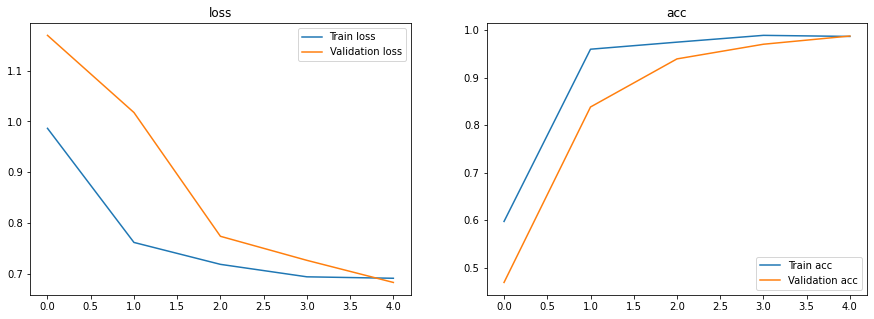

In [50]:
ngeplot(gambar)
model.load_weights(model_terbaik)
model_score = model.evaluate_generator(val_gen, steps = 20)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:", model_score[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
  json_file.write(model_json)

model.save('rockpaperscissor.h5')
print("Weights Saved")

Dari plot di atas menunjukkan bahwa:
1. pada graphik line yang berjudul loss menunjukkan bahwa kehilangan nilainya jua sedikit sekali.
2. pada grafik line yang berjudul acc, menunjukkan bahwa train accurasi dan validation accurasinya akurat. karena antara train dan validation tidak jomplang nilainya. Namun masih sama-sama antara 0.99 hampir menjadi 1.

sehingga dikatakan model ini bisa dijadikan untuk prediksi gunting, batu, kertas. karena tidak overfitting atau underfitting

# Memulai Prediksi

Saving gunting.jpeg to gunting (1).jpeg
[1]
Gunting


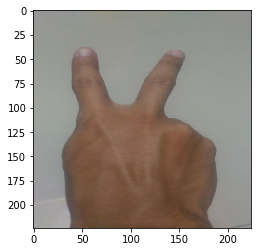

In [52]:
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
from keras.models import load_model
upload = files.upload()
for fn in upload.keys():
  #predicting images
  path = fn
  img = image.load_img(path, target_size = (224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
model = load_model('rockpaperscissor.h5')
images = np.vstack([x])
pred = model.predict_classes(images,batch_size=10)

print(pred)
if pred == 1:
  print('Gunting')
else:
  print('Non')